# Задания

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr
import locale
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')

## Доверительные интервалы

### Задание 1

Построй диаграмму зависимости количества проданной пиццы от дня недели.
Вывести дни недели, в которые продано **больше** и  **меньше** всего пиццы.

In [2]:
df = pd.read_csv('pizza.csv', delimiter=';', low_memory=False)

# Преобразуем имеющийся формат строки в формат даты, получаем день недели, язык русский:
locale.setlocale(locale.LC_ALL,'ru')
df['day_week'] = pd.to_datetime(df['order_date']).dt.strftime('%A')

# Находим продажи по дням недели:
pizza_count_sales = df['day_week'].value_counts()

# Находим максимальное и минимальное количество продаж по дням недели:
pizza_max = pizza_count_sales.idxmax()
pizza_min = pizza_count_sales.idxmin()

print(f'Больше всего пиццы продано в {pizza_max}')
print(f'Меньше всего пиццы продано в {pizza_min}')

Больше всего пиццы продано в четверг
Меньше всего пиццы продано в воскресенье


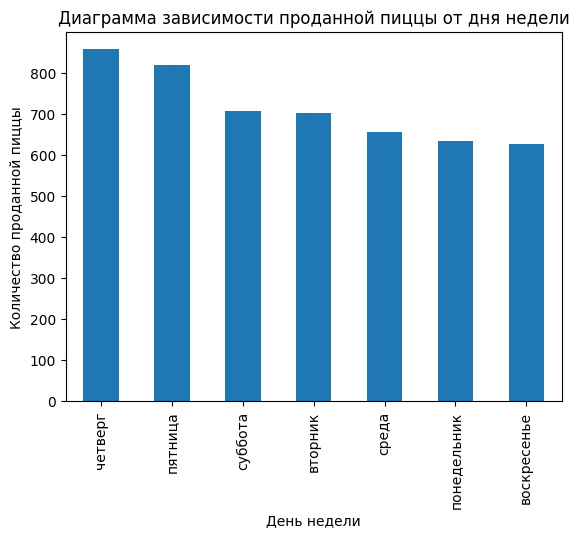

In [3]:
# Строим диаграмму завиимости проданной пиццы от дня недели:
pizza_count_sales.plot(kind='bar')
plt.xlabel('День недели')
plt.ylabel('Количество проданной пиццы')
plt.title('Диаграмма зависимости проданной пиццы от дня недели')
plt.show()

### Задание 2

Посчитай, сколько **секунд** необходимо для приготовления каждой пиццы по всем заказам. Значения сохранить в новый столбец - `cook_time`. Найти среднее, медианное, максимальное и минимальное время приготовления пиццы. Результат округлите до целого.

In [4]:
# Создаем новую колонку "дата и время":
df['order_datetime'] = pd.to_datetime(df['order_date'] + ' ' + df['order_time'])

# Преобразуем строку в формат даты:
df['lead_time'] = pd.to_datetime(df['lead_time'], format='%Y-%m-%d %H:%M:%S')

# Вычисляем временя приготовления пиццы в секундах:
df['cook_time'] = (df['lead_time'] - df['order_datetime']).dt.total_seconds()
df['cook_time'] = df['cook_time'].astype(int)

# Вычисляем среднее, медианное, максимальное и минимальное временя приготовления пиццы:
mean_cook_time = round(df['cook_time'].mean())
median_cook_time = round(df['cook_time'].median())
max_cook_time = round(df['cook_time'].max())
min_cook_time = round(df['cook_time'].min())

print("СРЕДНЕЕ время приготовления пиццы -", mean_cook_time)
print("МЕДИАННОЕ время приготовления пиццы -", median_cook_time)
print("МАКСИМАЛЬНОЕ время приготовления пиццы -", max_cook_time)
print("МИНИМАЛЬНОЕ время приготовления пиццы -", min_cook_time)

СРЕДНЕЕ время приготовления пиццы - 1007
МЕДИАННОЕ время приготовления пиццы - 1006
МАКСИМАЛЬНОЕ время приготовления пиццы - 1609
МИНИМАЛЬНОЕ время приготовления пиццы - 444


### Задание 3

Построй 95% доверительный интервал для среднего времени приготовления пиццы в **секундах**. Интервал округли до целого
> Для расчета стандартного отклонения используй `numpy.std(ddof=1)`

In [5]:
# Вычисляем стандартное отклонение и определяем размер выборки:
std_cook_time = np.std(df['cook_time'], ddof=1)
n = len(df['cook_time'])

# Вычисляем и округляем доверительный интервал для среднего времени приготовления пиццы в секундах:
interval = st.norm.interval(0.95, loc=mean_cook_time, scale=std_cook_time/np.sqrt(n))
interval = (round(interval[0]), round(interval[1]))

print(f'95% доверительный интервал для среднего времени приготовления пиццы в секундах - {interval}')

95% доверительный интервал для среднего времени приготовления пиццы в секундах - (1002, 1012)


### Задание 4

Хозяин ресторана хочет оптимизировать меню ресторана. При формировании цены на пиццу хозяин хочет учитывать время 
её изготовления. Давай найдем ту пиццу (pizza_name), у которой верхняя граница доверительного интервала её изготовления 
самая высокая.
> Среди пицц, у которых за все время заказывали более 100 штук

In [6]:
# Создаем список пицц, заказанных более 100 штук:
pizza_count_100 = df['pizza_name'].value_counts()
pizza_top = pizza_count_100[pizza_count_100 > 100].index.tolist()

# Определяем верхнюю границу доверительного интервала:
interval_up = []
for pizza in pizza_top:
    df4_pizza = df.loc[df['pizza_name'] == pizza, 'cook_time']
    mean_cook_time = df4_pizza.mean()
    std_cook_time = np.std(df4_pizza, ddof=1)
    n = len(df4_pizza)
    interval = st.norm.interval(0.95, loc=mean_cook_time, scale=std_cook_time/np.sqrt(n))
    interval_up.append([interval[1], pizza])

# Ищем пиццу с максимальной верхней границей доверительного интервала:
interval_up.sort()

print(f'Пицца, у которой верхняя граница доверительного интервала времени ее изготовления, самая высокая - {interval_up[-1]}')

Пицца, у которой верхняя граница доверительного интервала времени ее изготовления, самая высокая - [1068.4259922985843, 'The Italian Vegetables Pizza']


### Задание 5

Также хозяину ресторана хочется убрать из меню пиццы с нестабильным временем изготовления. 
Давай найдем пиццу с самым широким доверительным интервалом.
> Среди пицц, у которых за все время заказывали более 100 штук

In [7]:
# Определяем верхнюю и нижнюю границу (ширину) доверительного интервала:
interval_wide = []
for pizza in pizza_top:
    df5_pizza = df.loc[df['pizza_name'] == pizza, 'cook_time']
    mean_cook_time = df5_pizza.mean()
    std_cook_time = np.std(df5_pizza, ddof=1)
    n = len(df5_pizza)
    interval = st.norm.interval(0.95, loc=mean_cook_time, scale=std_cook_time/np.sqrt(n))
        
    upper = interval[1]
    lower = interval[0]

    interval_wide.append([(upper - lower), pizza])

# Определяем пиццу с самым широким доверительным интервалом:
interval_wide.sort()

print(f'Пицца с самым широким доверительным интервалом - {interval_wide[-1]}')

Пицца с самым широким доверительным интервалом - [72.45100296026135, 'The Chicken Alfredo Pizza']


## AB тестирование

### Задание 6

В качестве нулевой гипотезы (H0) выберем, что старый баннер лучше нового.  В качестве альтернативной гипотезы (H1) выберем, 
что новый баннер лучше старого. Построй 95% доверительный интервал для доли каждого из баннеров, используя метод 
[proportion_confint](https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html)
библиотеки statsmodels. Пересекаются ли эти интервалы?

In [8]:
df6 = pd.read_csv('click.csv')

# Рассчитываем успех каждой гипотезы и общего количества испытаний:
count_a = df6['banner_a'].sum()
count_b = df6['banner_b'].sum()
nobs = len(df6)

# Определяем доверительных интервалов:
click_a = proportion_confint(count_a, nobs, alpha=0.05, method='normal')
click_b = proportion_confint(count_b, nobs, alpha=0.05, method='normal')

print(f'Доверительный интервал для доли старого баннера: {click_a}')
print(f'Доверительный интервал для доли нового баннера: {click_b}')

if click_a[1] == click_a[0] or click_a[0] == click_a[1]:
    print('Интервалы не пересекаются')
else:
    print('Интервалы пересекаются')

Доверительный интервал для доли старого баннера: (0.02530064022092865, 0.04869935977907135)
Доверительный интервал для доли нового баннера: (0.03911451622486782, 0.06688548377513218)
Интервалы пересекаются


### Задание 7

Для более детальной оценки построй 95% доверительный интервал для разности двух долей.
**Ответ дай в формате:**\
95% доверительный интервал для разности двух долей: [0.99847, 9.99847]

Левая и правая границы доверительного интервала рассчитываются по формулам:
$$p_a - p_b \pm z * \sqrt{\frac{p_a(1 - p_a)}{n_a} + \frac{p_b(1 - p_b)}{n_b}}$$
Где

$p_a = \frac{n_{like(a)}}{n_{a}}$,

$p_b = \frac{n_{like(b)}}{n_{b}}$,

$z = 1-\frac{\alpha}{2}$ (используй scipy.stats.norm.ppf)

$n_a$ - общее количество кликов по баннеру а

$n_b$ - общее количество кликов по баннеру b

$n_{like(a)}$ - количество лайков по баннеру а

$n_{like(b)}$ - количество лайков по баннеру b

In [9]:
# Определяем доверительный интервал:
pa = count_a / nobs
pb = count_b / nobs
z = st.norm.ppf(1 - 0.05 / 2)
left = round(pa - pb - z * np.sqrt((pa * (1 - pa) + pb * (1 - pb)) / nobs), 5)
right = round(pa - pb + z * np.sqrt((pa * (1 - pa) + pb * (1 - pb)) / nobs), 5)
print(f'95% доверительный интервал разности двух долей: [{left}, {right}]')

95% доверительный интервал разности двух долей: [-0.03416, 0.00216]


### Задание 8

Проведи АБ-тест. Какой баннер лучше? H0 - Старый баннер или H1 - новый баннер.
В этом тебе поможем функция [z-критерия](code-samples/stats.py).

$$Z({X_1, X_2}) =  \frac{p_a - p_b}{\sqrt{P(1 - P)(\frac{1}{n_a} + \frac{1}{n_b})}}$$
$$P = \frac{p_a{n_a} + p_b{n_b}}{{n_a} + {n_b}} $$

$p_a, p_b = \frac{∑кликов}{n}$, n - общее количество кликов по баннеру

$n_a$ - общее количество кликов по баннеру а

$n_b$ - общее количество кликов по баннеру b

In [10]:
def z_stat(sample1, sample2):
    n_a = len(sample1)
    n_b = len(sample2)

    p_a = float(sum(sample1)) / n_a
    p_b = float(sum(sample2)) / n_b 
    P = float(p_a * n_a + p_b * n_b) / (n_a + n_b)
   
    return (p_a - p_b) / np.sqrt(P * (1 - P) * (1. / n_a + 1. / n_b))

In [11]:
# Определяем, какой баннер лучше:
z = abs(z_stat(df6['banner_a'], df6['banner_b']))

if z > 0:
    print('Нулевую гипотезу отвергаем, новый баннер больше нравится пользователям')
else:
    print('Нулевую гипотезу принимаем, старый баннер больше нравится пользователям')

Нулевую гипотезу отвергаем, новый баннер больше нравится пользователям


## Корреляции

### Задание 9

Прочитай про корреляции Пирсона и Спирмена. Узнай какие связи между выборками они способны находить. По сгенерированным выборкам посчитай коррелицию Пирсона и Спирмена для выборок `x-y1`, `x-y2`, `x-y3`. Отрисуй выборки в формате, как показано ниже:
<img src="../misc/images/corr.png">

Объясни, почему получается такое значение корреляций.

In [12]:
x = np.linspace(-10,10,100)
y1 = x ** 2
y2 = -x **2
y3 = np.log(x ** 2 + 1)

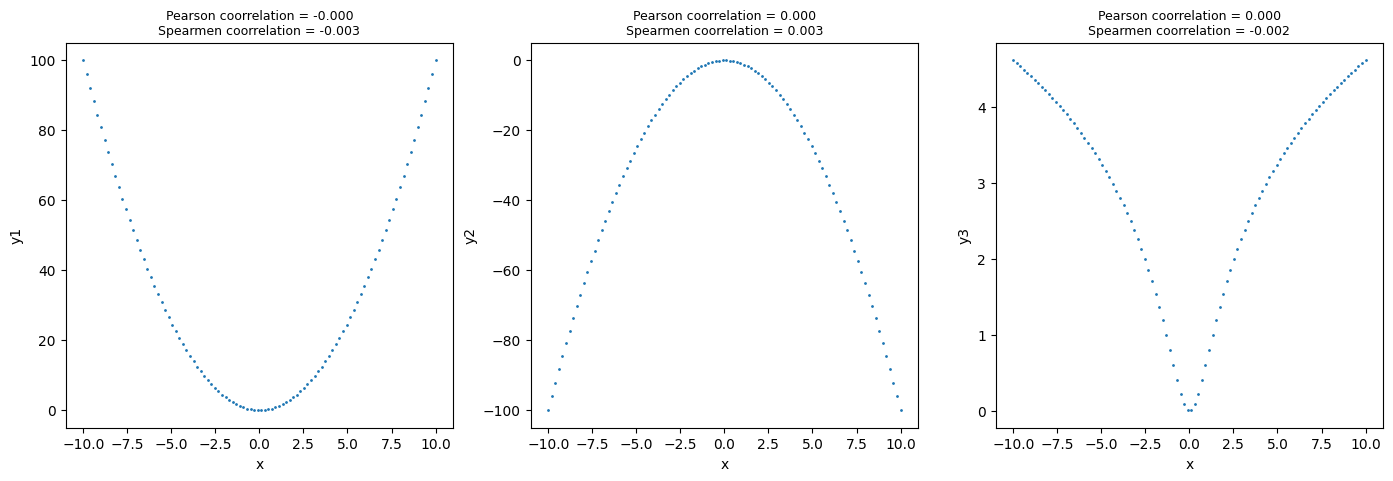

In [13]:
# Определяем корреляцию Пирсона:
pears_1 = st.pearsonr(x, y1)[0]
pears_2 = st.pearsonr(x, y2)[0]
pears_3 = st.pearsonr(x, y3)[0]

# Определяем корреляцию Спирмена:
sp_1 = st.spearmanr(x, y1)[0]
sp_2 = st.spearmanr(x, y2)[0]
sp_3 = st.spearmanr(x, y3)[0]

# Строим графики:
figure, axis = plt.subplots(1, 3, figsize = (17,5))

axis[0].scatter(x, y1, s = 1)
axis[0].set_xlabel('x')
axis[0].set_ylabel('y1')
axis[0].set_title(f'Pearson coorrelation = {pears_1:.3f}\nSpearmen coorrelation = {sp_1:.3f}', fontsize = 9)

axis[1].scatter(x, y2, s = 1)
axis[1].set_xlabel('x')
axis[1].set_ylabel('y2')
axis[1].set_title(f'Pearson coorrelation = {pears_2:.3f}\nSpearmen coorrelation = {sp_2:.3f}', fontsize = 9)

axis[2].scatter(x, y3, s = 1)
axis[2].set_xlabel('x')
axis[2].set_ylabel('y3')
axis[2].set_title(f'Pearson coorrelation = {pears_3:.3f}\nSpearmen coorrelation = {sp_3:.3f}', fontsize = 9)

plt.show()

Коэффициент корреляции Пирсона измеряет линейную связь между двумя наборами данных. Как и другие коэффициенты корреляции, этот варьируется от -1 до +1, причем 0 означает отсутствие корреляции. Корреляции -1 или +1 подразумевают точную линейную зависимость. Положительные корреляции подразумевают, что с увеличением x увеличивается и y. Отрицательные корреляции подразумевают, что по мере увеличения x y уменьшается.

Коэффициент ранговой корреляции Спирмена является непараметрической мерой монотонности отношений между двумя наборами данных. Как и другие коэффициенты корреляции, этот варьируется от -1 до +1, причем 0 означает отсутствие корреляции. Корреляции -1 или +1 подразумевают точную монотонную зависимость. Положительные корреляции подразумевают, что с увеличением x увеличивается и y. Отрицательные корреляции подразумевают, что по мере увеличения x y уменьшается.

Т.к. в данном задании коэффициент Пирсона близок к 0, это означает, что зависимость между наборами данных нелинейная. Коэффициент Спирмена также близок к 0, значит, что нет монотонной зависимости между выборками.

### Задание 10


Построй облако из тысячи точек c помощью приведенного кода.
Выведи значения коэффициентов корреляции.
Случайным образом выбери четыре точки. Каждую из точек передвигать в правый верхний угол относительно облака точек 
(тем самым создавая выброс):
значения по оси х 25, 50, 150, 650
по оси y 20, 40, 60, 80.
Выводи на графике перемещения точек.
Для каждого расстояния рассчитай коэффициент корреляции Пирсона и Спирмана.
Какая корреляция больше устойчива к выбросам?

In [14]:
step = np.linspace(-10, 0, 1000)
x = -step + np.random.randn(1000) * 0.2
y = step + np.random.randn(1000) * 0.2

Коэффициент корреляции Пирсона =-0.9951284087285497
Коэффициент корреляции Спирмена =-0.9952656232656234


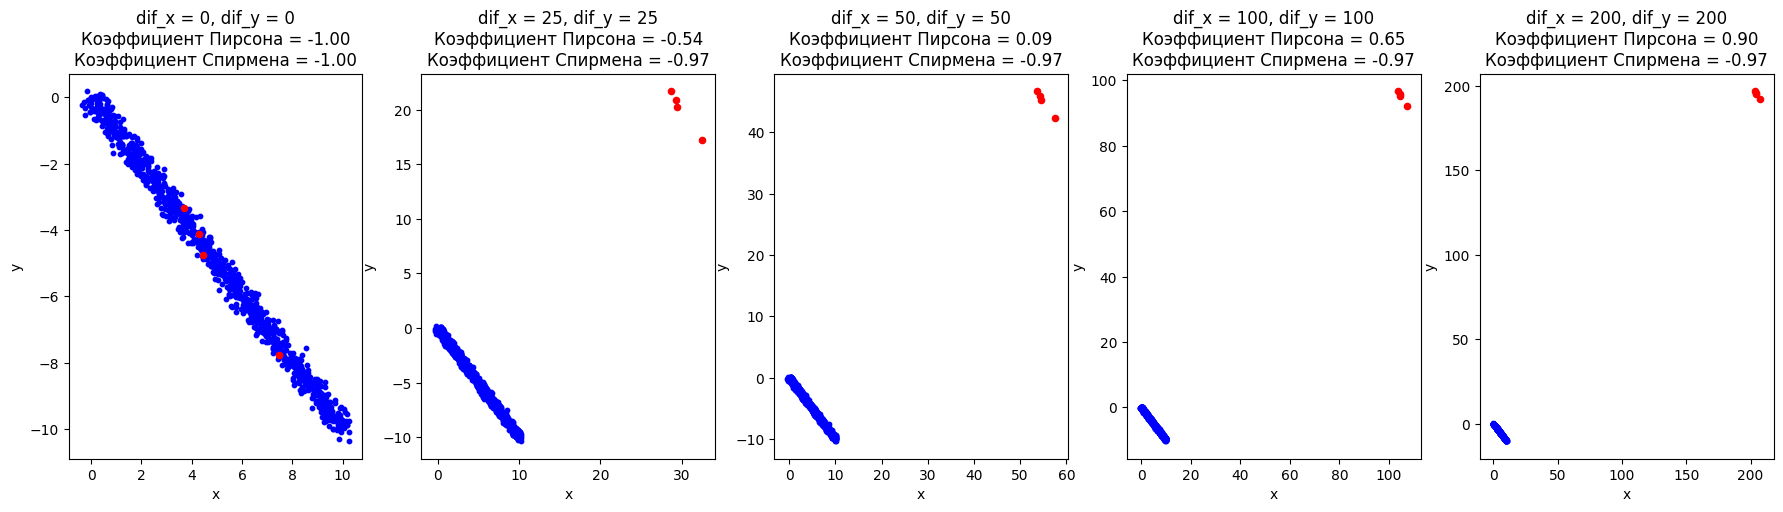

In [15]:
# Выводим значения коэффициентов корреляции Пирсона и Спирмена:
pears = st.pearsonr(x, y)[0]
sp = st.spearmanr(x, y)[0]
print(f'Коэффициент корреляции Пирсона ={pears}\nКоэффициент корреляции Спирмена ={sp}')

# Определяем списки dif_x и dif_y:
dif_x = [0, 0, 25, 50, 100, 200]
dif_y = [0, 0, 25, 50, 100, 200]

# Генерируем случайный список из четырех индексов:
r_ind = np.random.choice(len(x), size=4, replace=False)

# Строим графики:
figure, axis = plt.subplots(1, 5, figsize = (22,5))

for j in range(5):
    
    for i in range(4):

        # Перемещаем каждую точку: 
        x[r_ind[i]] = x[r_ind[i]] - dif_x[j] + dif_x[j+1]
        y[r_ind[i]] = y[r_ind[i]] - dif_y[j] + dif_y[j+1]
    
        # Вычисляем корреляцию:
        pears = st.pearsonr(x, y)[0]
        sp = st.spearmanr(x, y)[0]
    
    # Выводим график для каждого перемещения точек:
    axis[j].scatter(x, y, s=10, c='blue', label='Облако из тысячи точек')
    axis[j].scatter(x[r_ind], y[r_ind], s=20, c='red', label='Перемещенные точки')
    axis[j].set(xlabel = 'x', ylabel = 'y', title = f'dif_x = {dif_x[j+1]}, dif_y = {dif_y[j+1]}\nКоэффициент Пирсона = {pears:.2f}\nКоэффициент Спирмена = {sp:.2f}')